![]../img/330-banner.png)

Lecture 5: SVM, Preprocessing and `sklearn` pipelines
------------
UBC 2022-23 W2

Instructor: Amir Abdi

iclicker link: https://join.iclicker.com/EMMJ <img src="img_aa/iclicker_qr_code.png" height="300" width="300"> 

<!--
replace (img/ wih (../img/  
replace https://join.iclicker.com/3DP5H with https://join.iclicker.com/EMMJ
replace "data/ with "../data/
copy legends
copy setup cell
-->

## Announcements
- Homework 3 is out. Please start early. 
- Homework 1 solutions will be posted on Canvas. Please do not share them with anyone or do not post them anywhere. 


## Learning outcomes

From this lecture, you will be able to 

- have another glimpse at **SVM**
- explain motivation for **preprocessing** in supervised machine learning;
- identify when to implement **feature transformations** such as **imputation, scaling, and one-hot encoding** in a machine learning model development pipeline; 
- use `sklearn` transformers for applying feature transformations on your dataset;
- discuss golden rule in the context of feature transformations;
- use `sklearn.pipeline.Pipeline` and `sklearn.pipeline.make_pipeline` to build a preliminary machine learning pipeline. 

**Imports**

In [1]:
import sys
import time

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
import pandas as pd
from IPython.display import HTML

sys.path.append("../code/.")

import mglearn
from IPython.display import display

# Classifiers and regressors
from sklearn.dummy import DummyClassifier, DummyRegressor

# Preprocessing and pipeline
from sklearn.impute import SimpleImputer

# train test split and cross validation
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

pd.set_option("display.max_colwidth", 200)

# SVM

To properly learn **SVM**s, you need to learn about:
- kernels (polynomial kernels, RBF kernel) --> not coverered here
- support vectors
- soft/hard SVMs
- regularization

<br><br><br><br><br><br>

## Kernel (kernel trick)
- A method to use a linear-model to solve a non-linear problem.
- A more efficient (less computationally expensive) way to transform data into higher dimensions


<img src="https://miro.medium.com/max/4800/1*mCwnu5kXot6buL7jeIafqQ.webp">


Figure reference: https://medium.com/@zxr.nju/what-is-the-kernel-trick-why-is-it-important-98a98db0961d

<br><br><br><br><br><br><br><br>
An SVM used for **C**lassificatio is called **SVC**  
Simiilarly,  
An SVM used for **R**egression is called **SVR**  
<br><br><br><br><br><br><br><br>

## SVC (SVM for classification) with RBF kernel

Let's try SVMs on the cities dataset. 

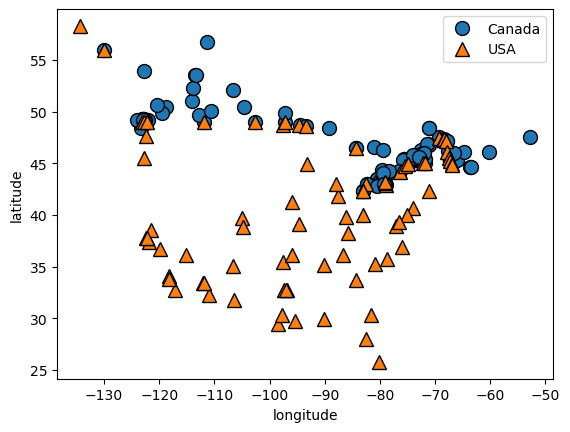

In [2]:
cities_df = pd.read_csv("../data/canada_usa_cities.csv")
X_cities = cities_df[["longitude", "latitude"]]
y_cities = cities_df["country"]

mglearn.discrete_scatter(X_cities.iloc[:, 0], X_cities.iloc[:, 1], y_cities)
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.legend(loc=1);

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X_cities, y_cities, test_size=0.2, random_state=123
)

In [4]:
from sklearn.svm import SVC

# ------ New Class: SVC! ------
svm = SVC(gamma=0.01)  # Ignore gamma for now
svm.fit(X_train, y_train)
test_score = svm.score(X_test, y_test)
# -----------------------------

print("Test score %0.3f" % test_score)

Test score 0.833


## Decision boundary of SVMs 
- We can think of SVM with RBF kernel as "smooth KNN". 

C:\Users\Michelle Wang\miniconda3\envs\cpsc330\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Michelle Wang\miniconda3\envs\cpsc330\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


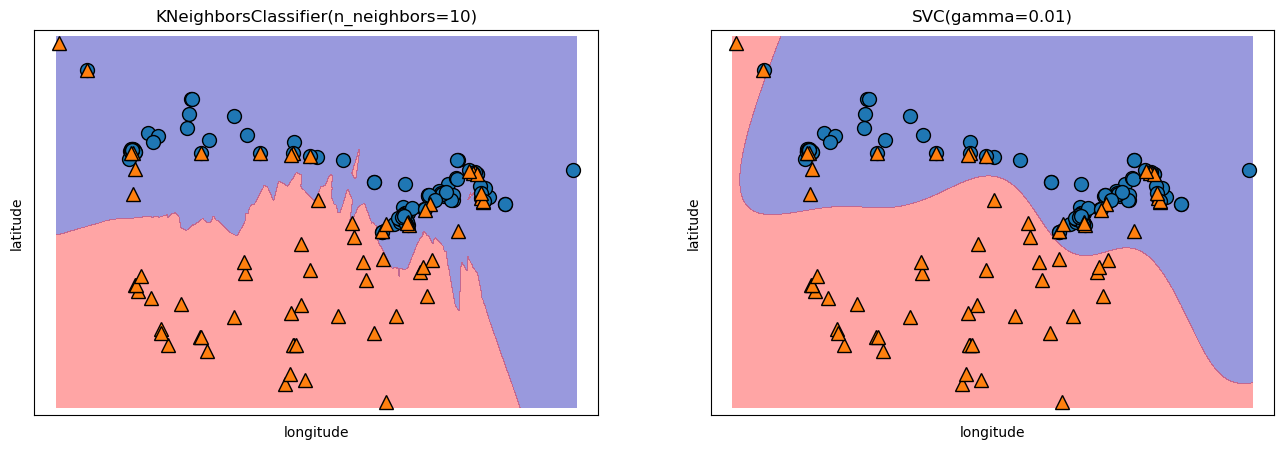

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

svm = SVC(gamma=0.01)  # Ignore gamma for now
knn = KNeighborsClassifier(n_neighbors=10)

for clf, ax in zip([knn, svm], axes):
    clf.fit(X_train, y_train)
    mglearn.plots.plot_2d_separator(
        clf, X_train.to_numpy(), fill=True, eps=0.5, ax=ax, alpha=0.4
    )
    mglearn.discrete_scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], y_train, ax=ax)
    ax.set_title(clf)
    ax.set_xlabel("longitude")
    ax.set_ylabel("latitude")

## Support vectors 

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/72/SVM_margin.png/1920px-SVM_margin.png" width="500">

[img source](https://en.wikipedia.org/wiki/Support_vector_machine)

- Each **training example** either is or isn't a "support vector".
  - This gets decided during `fit`.

- **Main insight: the decision boundary only depends on the support vectors.**

- Let's look at the support vectors. 

In [6]:
from sklearn.datasets import make_blobs

n = 20
n_classes = 2
X_toy, y_toy = make_blobs(
    n_samples=n, centers=n_classes, random_state=300
)  # Let's generate some fake data

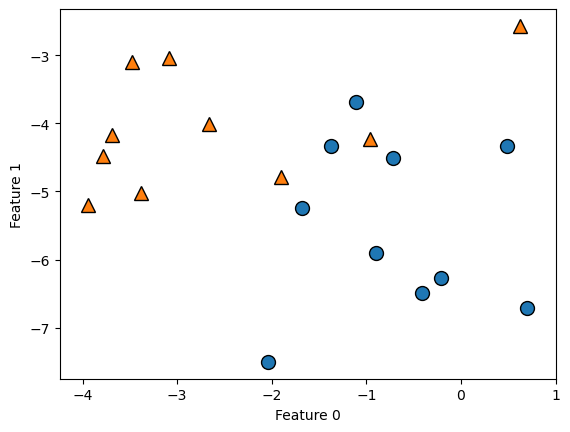

In [7]:
mglearn.discrete_scatter(X_toy[:, 0], X_toy[:, 1], y_toy)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1");

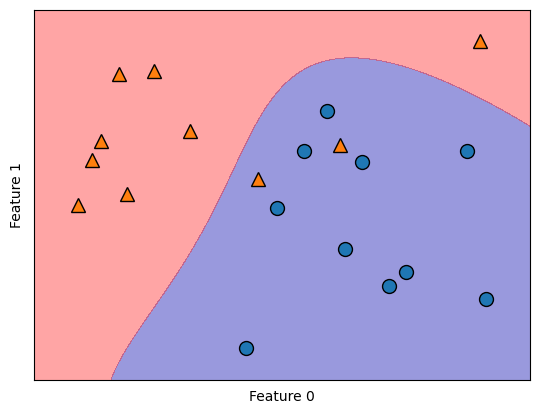

In [8]:
mglearn.discrete_scatter(X_toy[:, 0], X_toy[:, 1], y_toy)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1");

svm = SVC(kernel="rbf", C=10, gamma=0.1).fit(X_toy, y_toy)
mglearn.plots.plot_2d_separator(svm, X_toy, fill=True, eps=0.5, alpha=0.4)

In [9]:
svm.support_

array([ 3,  8,  9, 14, 19,  1,  4,  6, 17])

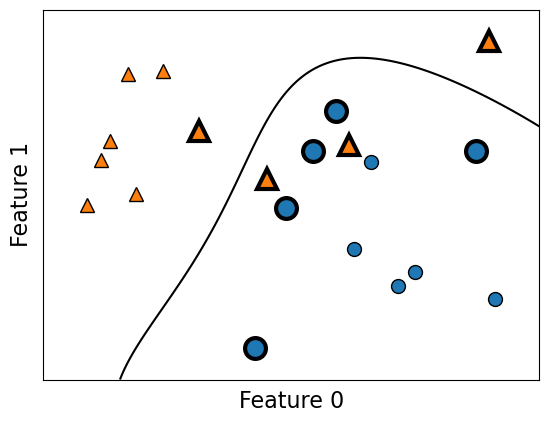

In [10]:
from plotting_functions import plot_support_vectors
plot_support_vectors(svm, X_toy, y_toy)

The support vectors are the bigger points in the plot above. 

### Hyperparameters of SVM 

- Important hyperparameter of **RBF (Radial Basis Function)**:
  - `gamma`: Defines **how far** the influence of a single training example reaches


- Important hyperparameter of SVM:
  - `C` (**regularization**): The C parameter **trades off correct classification** vs. **maximization of the decision margin**
    - Larger `C` --> less regularization
    - Smaller `C` --> more regularization (simpler function)


<br><br><br><br>
We are not equipped to understand the meaning of these parameters at this point but you are expected to describe their relation to the fundamental tradeoff. 

See [`scikit-learn`'s explanation of RBF SVM parameters](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html). 




**Interactive demo: (a very good demo!)**
- https://dash.gallery/dash-svm/ (code is here: https://github.com/plotly/dash-sample-apps/tree/main/apps/dash-svm)
<br><br><br><br>

### Relation of `gamma` and the fundamental trade-off

- `gamma` controls the complexity (fundamental trade-off), just like other hyperparameters we've seen.
  - larger `gamma` $\rightarrow$ each point influences close, **more complex**
  - smaller `gamma` $\rightarrow$ each point influence far away, **less complex**

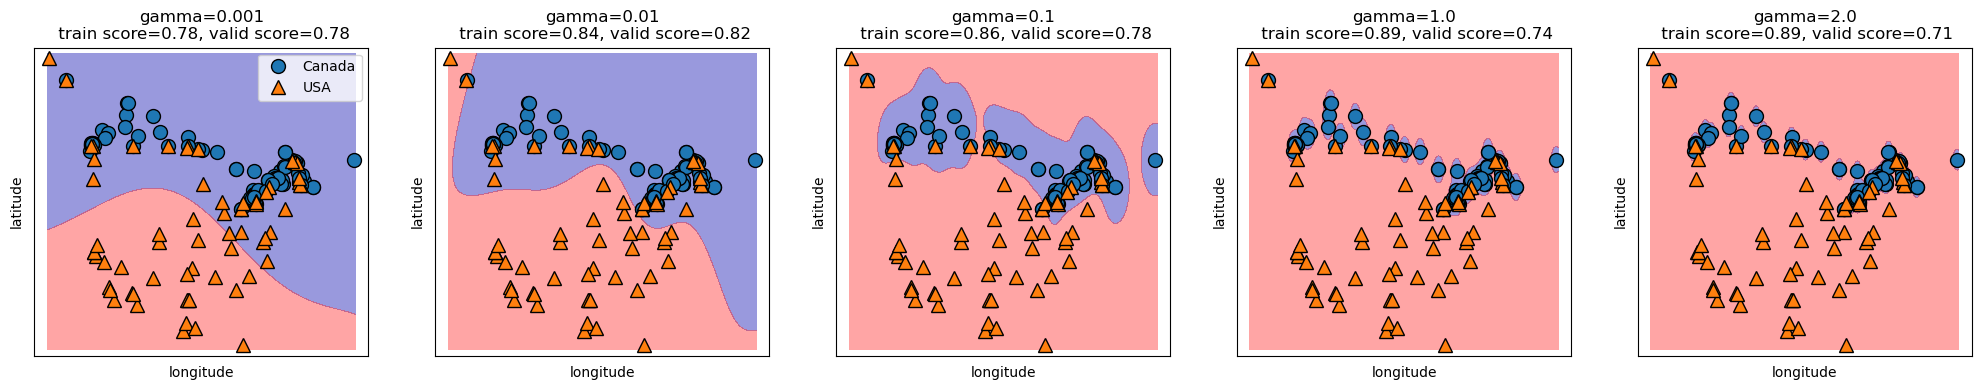

In [11]:
from plotting_functions import plot_svc_gamma
matplotlib.rc('font', **{'size'   : 10})

gamma = [0.001, 0.01, 0.1, 1.0, 2.0]
plot_svc_gamma(
    gamma,
    X_train.to_numpy(),
    y_train.to_numpy(),
    x_label="longitude",
    y_label="latitude",
)

### Relation of `C` and the fundamental trade-off

- `C` _also_ affects the fundamental tradeoff
- The bigger the `C` the more you **penalize misclssification**
    - larger `C` $\rightarrow$ penalize more, **more complex**, smaller decision margin
    - smaller `C` $\rightarrow$ penalize less, **less complex**, bigger decision margin
    

<br><br>

----------------
[Not covered in class; for students to read out of **their never-ending curiosity to learn more**]
### $nu$-SVM **[Optional/Bonus Content]**
There is another version of SVM calld **$\nu$-SVM** where `C` is replaced by `nu`
- `nu` ranges from 0 to 1
- `C` ranges from 0 to infinity
- **Larger values of `nu`** correspond to **smaller values of `C`**
- **Smaller values of `nu`** correspond to **larger values of `C`**
- `C = infinity` $\rightarrow$ `nu = 0` $\rightarrow$ HARDer margin
- `C = 0` $\rightarrow$ `nu = 1` $\rightarrow$ SOFTer margin
- This demo is basd on $nu$-SVM
  - https://greitemann.dev/svm-demo

----------------

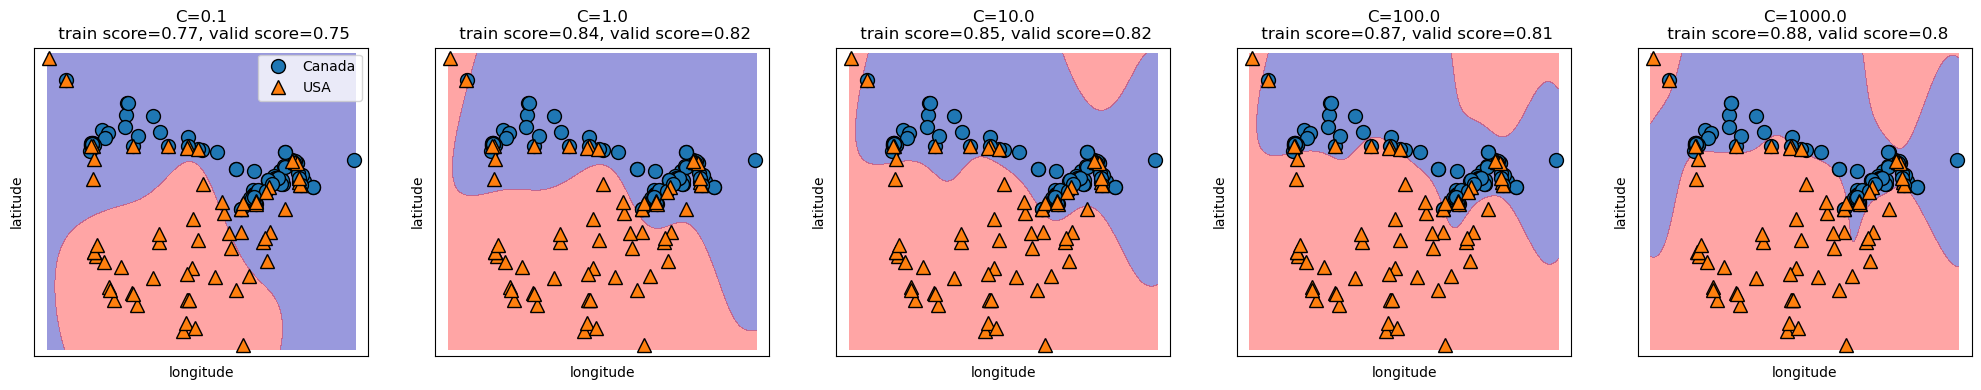

In [12]:
from plotting_functions import plot_svc_C
matplotlib.rc('font', **{'size'   : 10})

C = [0.1, 1.0, 10.0, 100.0, 1000.0]
plot_svc_C(
    C, X_train.to_numpy(), y_train.to_numpy(), x_label="longitude", y_label="latitude"
)

### SVM Regressor

- Similar to KNNs, you can use SVMs for regression problems as well.
- See [sklearn.svm.SVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html) for more details.

## ❓❓ Questions for you 

## (iClicker) Exercise 4.2 

**iClicker cloud join link: https://join.iclicker.com/EMMJ**

**Select all of the following statements which are TRUE.**

1. $k$-NN may perform poorly in high-dimensional space (say, *d* > 1000). 
2. In SVM with RBF kernel, removing a non-support vector would not change the decision boundary. 
3. In Linear SVM, removing a non-support vector would not change the decision boundary.
4. In sklearn’s SVC classifier, very large values of gamma tend to result in higher training score but probably lower validation score. 
5. If we increase both gamma and C, we can't be certain if the model becomes more complex or less complex.


TRUE responses are: 
1
2
3
4


<br><br><br><br><br><br><br><br><br><br><br><br><br><br>

# 2. HParam Search over multiple hyperparameters
What to do when you have 2+ HParam to decide?

- Best validation error requires a hyperparameter search to **balance the fundamental (bias/variance) tradeoff**.
- How do you check all values of all Hyper-Parameters to decide the **best set of HParams?**

- More on this next week. But if you cannot wait till then, you may look up the following:
    - [sklearn.model_selection.GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
    - [sklearn.model_selection.RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

#### Randomized hyperparameter search

- Randomized hyperparameter optimization: [`sklearn.model_selection.RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
- Samples configurations at random until certain budget (e.g., time) is exhausted.
- Advantage: you can choose how many runs you'll do.
- Advantage: you can restrict yourself less on what values you might try.
- Advantage: Adding parameters that do not influence the performance does not affect efficiency.
- Advantage: research shows this is generally a better idea than grid search, see image for intuition:

![](../img/randomsearch_bergstra.png)

Source: [Bergstra and Bengio, Random Search for Hyper-Parameter Optimization, JMLR 2012](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf).

- You don't know in advance which hyperparameters are important for your problem.
- But some of them might be unimportant.
- In the left figure, 6 of the 9 searches are useless because they are only varying the unimportant parameter.
- In the right figure, all 9 searches are useful.

# 3. Feature Engineering [[video](https://youtu.be/xx9HlmzORRk)]

**[Watch after the class if you haven't already]**
- So far we have seen
    - Three ML models (decision trees, $k$-NNs, SVMs)
    - ML fundamentals (train-validation-test split, cross-validation, the fundamental tradeoff, the golden rule)

## Scaling 

Reminder from last session: KNN models are very sensitive to **scale** of features

### Example: $k$-nearest neighbours on the Spotify dataset

- In lab1 you used `DecisionTreeClassifier` to predict whether the user would like a particular song or not. 
- Can we use $k$-NN classifier for this task? 
- Intuition: To predict whether the user likes a particular song or not (query point) 
   - find the songs that are closest to the query point
   - let them vote on the target
   - take the majority vote as the target for the query point   

In order to run the code below, you need to download the dataset from [Kaggle](https://www.kaggle.com/geomack/spotifyclassification/download).

In [13]:
spotify_df = pd.read_csv("../data/spotify.csv", index_col=0)
train_df, test_df = train_test_split(spotify_df, test_size=0.20, random_state=123)
X_train, y_train = (
    train_df.drop(columns=["song_title", "artist", "target"]),
    train_df["target"],
)
X_test, y_test = (
    test_df.drop(columns=["song_title", "artist", "target"]),
    test_df["target"],
)

In [14]:
knn = KNeighborsClassifier()
scores = cross_validate(knn, X_train, y_train, return_train_score=True)
print("Mean validation score %0.3f" % (np.mean(scores["test_score"])))

Mean validation score 0.546


In [15]:
two_songs = X_train.sample(2, random_state=42)
two_songs

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
842,0.229000,0.494,147893,0.666,0.000057,9,0.0469,-9.743,0,0.0351,140.832,4.0,0.704
654,0.000289,0.771,227143,0.949,0.602000,8,0.5950,-4.712,1,0.1750,111.959,4.0,0.372


------------
**[To study at home - The impact of feature scale on Euclidean distances]**

In [16]:
from sklearn.metrics import euclidean_distances

print('euclidean_distance of two songs: ', euclidean_distances(two_songs)[0,1])

euclidean_distance of two songs:  79250.00543825077


Let's consider only **one feature** of these two songs: `duration_ms`.

In [17]:
two_songs_duration = two_songs[["duration_ms"]]
two_songs_duration

,duration_ms
842,147893
654,227143


In [18]:
print('euclidean_distance of two songs: ', euclidean_distances(two_songs)[0,1])
print('euclidean_distance of two songs only duration: ', euclidean_distances(two_songs_duration)[0,1])

euclidean_distance of two songs:  79250.00543825077
euclidean_distance of two songs only duration:  79250.0


Do you see any problem? Duration seems to be like the only contributing feature

------------

- The distance is completely dominated by the the features with larger values
- The features with smaller values are being ignored. 
- Does it matter? 
    - Yes! Scale is based on how data was collected. 
    - Features on a smaller scale can be highly informative and there is no good reason to ignore them.
    - We **sometimes** want our model to be **invariant to the scale.** (search online and learn about the term "**invariance**")
- **Do decision trees suffer from the same problem?**
  - scale doesnt matter for decision tree because at each level there is only one feature that contributes
  - answer is NO

### Scaling using `scikit-learn`'s [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

- We'll use `scikit-learn`'s [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), which is a `transformer`.   
- Only focus on the syntax for now. We'll talk about scaling in a bit. 

In [19]:
X_train.head() # original X_train

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
1505,0.00477,0.585,214740,0.614,0.000155,10,0.0762,-5.594,0,0.0370,114.059,4.0,0.2730
813,0.11400,0.665,216728,0.513,0.303000,0,0.1220,-7.314,1,0.3310,100.344,3.0,0.0373
615,0.03020,0.798,216585,0.481,0.000000,7,0.1280,-10.488,1,0.3140,127.136,4.0,0.6400
319,0.10600,0.912,194040,0.317,0.000208,6,0.0723,-12.719,0,0.0378,99.346,4.0,0.9490
320,0.02110,0.697,236456,0.905,0.893000,6,0.1190,-7.787,0,0.0339,119.977,4.0,0.3110


In [31]:
from sklearn.preprocessing import StandardScaler

# SCALING THE FEATURES
# ---- New class and new functions -----
scaler = StandardScaler()  # create feature trasformer object
scaler.fit(X_train)  # fitting the transformer on the train split. dont let model or scaler to see test data

X_train_scaled = scaler.transform(X_train)  # transforming the train split. After scaler is trained
X_test_scaled = scaler.transform(X_test)  # transforming the test split
# -----------------------------------

<br>
Now, let's compare `X_train` with `X_train_scaled`

In [21]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_train_scaled_df.head().round(3)

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
1505,-0.698,-0.195,-0.399,-0.318,-0.492,1.276,-0.738,0.396,-1.281,-0.618,-0.294,0.139,-0.908
813,-0.276,0.296,-0.374,-0.796,0.598,-1.487,-0.439,-0.052,0.781,2.728,-0.803,-3.781,-1.861
615,-0.600,1.111,-0.376,-0.947,-0.493,0.447,-0.400,-0.879,0.781,2.535,0.191,0.139,0.576
319,-0.307,1.809,-0.654,-1.722,-0.492,0.170,-0.763,-1.461,-1.281,-0.609,-0.840,0.139,1.825
320,-0.635,0.492,-0.131,1.057,2.723,0.170,-0.458,-0.176,-1.281,-0.653,-0.074,0.139,-0.754


In [33]:
print('[X_train]\t\tmean(duration_ms)=', X_train.duration_ms.mean())
print('[X_train_scaled]\tmean(duration_ms)=', X_train_scaled_df.duration_ms.mean(), '\n')

print('[X_train]\t\tstd(duration_ms)=', X_train.duration_ms.std())
print('[X_train_scaled]\tstd(duration_ms)=', X_train_scaled_df.duration_ms.std())

# scaled data has become standardized. average is close to zero. has 10^-17. 

[X_train]		mean(duration_ms)= 247114.82765034097
[X_train_scaled]	mean(duration_ms)= 8.369691245779234e-17 

[X_train]		std(duration_ms)= 81177.30030778678
[X_train_scaled]	std(duration_ms)= 1.0003101256083242


<br><br><br><br><br>
**StandardScaler**: Standardize features by removing the mean (`mean(feature) = 0`) and scaling to unit variance (`std(feature) = 1`).
<br><br><br><br><br>

---------
**[For students to explore at home]**

You can hand-calcualte the StandardScaler feature normalization with one line of code

For example, let's normalize value of the `energy` feature for the first sample

In [23]:
X_train['energy'].iloc[0] 

0.614

In [24]:
(X_train['energy'].iloc[0] - np.mean(X_train['energy']))/ X_train['energy'].std()

-0.3180174485124284

In [25]:
pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index).head().round(3)

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
1505,-0.698,-0.195,-0.399,-0.318,-0.492,1.276,-0.738,0.396,-1.281,-0.618,-0.294,0.139,-0.908
813,-0.276,0.296,-0.374,-0.796,0.598,-1.487,-0.439,-0.052,0.781,2.728,-0.803,-3.781,-1.861
615,-0.600,1.111,-0.376,-0.947,-0.493,0.447,-0.400,-0.879,0.781,2.535,0.191,0.139,0.576
319,-0.307,1.809,-0.654,-1.722,-0.492,0.170,-0.763,-1.461,-1.281,-0.609,-0.840,0.139,1.825
320,-0.635,0.492,-0.131,1.057,2.723,0.170,-0.458,-0.176,-1.281,-0.653,-0.074,0.139,-0.754


---------
<br><br><br><br><br><br>

--------------
**[Recap/Summary to study on your own at home]**

### `fit` and `transform` paradigm for "Feature Transformers"
- `sklearn` uses `fit` and `transform` paradigms for feature transformations. 
- We `fit` the transformer on the train split and then transform the train split as well as the test split. 
- **We apply the same transformations on the test split.**

(footnote: don't confuse these feature transformers with the ones that are popular these days in deep learning)

### `sklearn` API summary: estimators

Suppose `model` is a classification or regression model. 

```
model.fit(X_train, y_train)
X_train_predictions = model.predict(X_train)
X_test_predictions = model.predict(X_test)
```    


### `sklearn` API summary: feature transformers

Suppose `transformer` is a transformer used to change the input representation, for example, to tackle missing values or to scales numeric features.

```
transformer.fit(X_train, [y_train])
X_train_transformed = transformer.transform(X_train)
X_test_transformed = transformer.transform(X_test)
```  

- You can pass `y_train` in `fit` but it's usually ignored. It allows you to pass it just to be consistent with usual usage of `sklearn`'s `fit` method.   
- You can also carry out fitting and transforming in one call using `fit_transform`. But be mindful to **use it only on the train split** and **NOT on the test split**. 

------------------
<br><br><br><br><br><br><br><br><br><br>

- Let's check whether scaling makes any difference for $k$-NNs. 

In [35]:
knn_unscaled = KNeighborsClassifier()
knn_unscaled.fit(X_train, y_train)
print("Train score: %0.3f" % (knn_unscaled.score(X_train, y_train)))
print("Test score: %0.3f" % (knn_unscaled.score(X_test, y_test)))

Train score: 0.726
Test score: 0.552


In [36]:
knn_scaled = KNeighborsClassifier()
knn_scaled.fit(X_train_scaled, y_train)
print("Train score: %0.3f" % (knn_scaled.score(X_train_scaled, y_train)))
print("Test score: %0.3f" % (knn_scaled.score(X_test_scaled, y_test)))

# test score jumped up. knn is sensitive to scaling. 

Train score: 0.798
Test score: 0.686


- Conclusion: **Results of KNN improved with feature normalization**.
- **Note/Reminder (Golden Rule of ML)**: that I am a bit sloppy here and using the test set several times for teaching purposes. 
  - But when you build an ML pipeline, please do assessment on the test set only once.

### 3.1.6 Common preprocessing techniques

Some commonly performed feature transformation include:  
- **Scaling**: Scaling of numeric features
- **Imputation**: Tackling missing values
- **One-hot encoding**: Tackling categorical variables      
    

We can have one lecture on each of them! In this lesson our goal is to getting familiar with them so that we can use them to build ML pipelines. 

In the next part of this lecture, we'll build an ML pipeline using [California housing prices regression dataset](https://www.kaggle.com/harrywang/housing). In the process, we will talk about different feature transformations and how can we apply them so that we do not violate the golden rule. 

<br><br><br><br>

### Dataset, splitting, and baseline

We'll be working on [California housing prices regression dataset](https://www.kaggle.com/harrywang/housing) to demonstrate these feature transformation techniques. The task is to predict median house values in Californian districts, given a number of features from these districts. If you are running the notebook on your own, you'll have to download the data and put it in the data directory. 

In [28]:
housing_df = pd.read_csv("../data/housing.csv")
train_df, test_df = train_test_split(housing_df, test_size=0.1, random_state=123)

train_df.head()

FileNotFoundError: [Errno 2] No such file or directory: '../data/housing.csv'

Let's add some new features to the dataset which could help predicting the target: `median_house_value`. 

In [ ]:
# rooms_per_household
train_df = train_df.assign(
    rooms_per_household=train_df["total_rooms"] / train_df["households"]
)
test_df = test_df.assign(
    rooms_per_household=test_df["total_rooms"] / test_df["households"]
)

# bedrooms_per_household
train_df = train_df.assign(
    bedrooms_per_household=train_df["total_bedrooms"] / train_df["households"]
)
test_df = test_df.assign(
    bedrooms_per_household=test_df["total_bedrooms"] / test_df["households"]
)

# population_per_household
train_df = train_df.assign(
    population_per_household=train_df["population"] / train_df["households"]
)
test_df = test_df.assign(
    population_per_household=test_df["population"] / test_df["households"]
)

In [ ]:
train_df.head()

### When is it OK to do things before splitting? 

- Here it would have been OK to add new features before splitting because we are not using any global information in the data but only looking at one row at a time. 
- **But just to be safe and to avoid accidentally breaking the golden rule, it's better to do it after splitting.**

- **Question**: Should we remove `total_rooms`, `total_bedrooms`, and `population` columns? 
    - **Answer:** Probably (maybe yes, maybe no). We should run an **empirical study** to answer this question:
      - Train two models, 
        - one with these features
        - one without these features
      - Evaluate their performance
      - Compare the results
      - Decide whether to keep or remove the features.

In [ ]:
# train_df = train_df.drop(columns = ['population', 'total_rooms', 'total_bedrooms'])
# test_df =  test_df.drop(columns = ['population', 'total_rooms', 'total_bedrooms'])

## EDA (Exploratory Data Analysis)

In [ ]:
train_df.head()

The feature scales are quite different. 

In [37]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1613 entries, 1505 to 1534
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      1613 non-null   float64
 1   danceability      1613 non-null   float64
 2   duration_ms       1613 non-null   int64  
 3   energy            1613 non-null   float64
 4   instrumentalness  1613 non-null   float64
 5   key               1613 non-null   int64  
 6   liveness          1613 non-null   float64
 7   loudness          1613 non-null   float64
 8   mode              1613 non-null   int64  
 9   speechiness       1613 non-null   float64
 10  tempo             1613 non-null   float64
 11  time_signature    1613 non-null   float64
 12  valence           1613 non-null   float64
 13  target            1613 non-null   int64  
 14  song_title        1613 non-null   object 
 15  artist            1613 non-null   object 
dtypes: float64(10), int64(4), object(2)
mem

We have **one categorical feature** and all other features are **numeric features**. 

In [ ]:
train_df.describe()

- Seems like total_bedrooms column has some missing values. 
- This must have affected our new feature `bedrooms_per_household` as well. 

In [ ]:
housing_df["total_bedrooms"].isnull().sum()

In [ ]:
## (optional)
train_df.hist(bins=50, figsize=(20, 15));

<br><br><br><br>

------------
**[To study at home]**
Let's plot a few features into the same diagram:
- longitude
- latitude
- population_per_household
- median_house_value

In [38]:
## (optional)
train_df.plot(
    kind="scatter",
    x="longitude",
    y="latitude",
    alpha=0.4,
    s=train_df["population_per_household"],
    figsize=(10, 7),
    c="median_house_value",
    cmap=plt.get_cmap("jet"),
    colorbar=True,
    sharex=False,
);

KeyError: 'population_per_household'

-----------
<br><br><br><br><br><br>

Here is what we learned from the **EDA (Exploratory Data Analysis)**. 

- Some missing values in `total_bedrooms` column
- Scales are quite different across columns. 
- Categorical variable `ocean_proximity`

<br><br><br><br><br>
**Conclusion:**
Before starting the "modeling (finding the right model to solve the problem)", learn about the data via **EDA**
<br><br><br><br><br>


## 3.3 What all transformations we need to apply on the dataset? 


Read about [preprocessing techniques implemented in `scikit-learn`](https://scikit-learn.org/stable/modules/preprocessing.html).  

In [ ]:
# We are droping the categorical variable ocean_proximity for now. We'll come back to it in a bit.
X_train = train_df.drop(columns=["median_house_value", "ocean_proximity"])
y_train = train_df["median_house_value"]

X_test = test_df.drop(columns=["median_house_value", "ocean_proximity"])
y_test = test_df["median_house_value"]

### Let's first run our baseline model `DummyRegressor`

In [ ]:
results_dict = {}  # dictionary to store our results for different models

In [ ]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [ ]:
dummy = DummyRegressor(strategy="median")
results_dict["dummy"] = mean_std_cross_val_scores(
    dummy, X_train, y_train, return_train_score=True
)

In [ ]:
pd.DataFrame(results_dict)

<br><br><br><br>
**Reminder to watch:** Imputation and scaling [[video](https://youtu.be/G2IXbVzKlt8)]
<br><br><br><br>

## 3.4 Imputation 

<br><br><br><br>
**Imputation** is the process of replacing **missing data** with substituted values.
<br><br><br><br>

In [ ]:
X_train

In [ ]:
X_train.describe()

In [ ]:
knn = KNeighborsRegressor()
# knn.fit(X_train, y_train)

### What's the problem? 

```
ValueError: Input contains NaN, infinity or a value too large for dtype('float64').
```

- The classifier is not able to deal with missing values (NaNs).
- What are possible ways to deal with the problem? 
    - Delete the rows? 
    - Replace them with some reasonable values?    

- `SimpleImputer` is a transformer in `sklearn` to deal with this problem. For example, 
    - You can impute missing values in categorical columns with the most frequent value.
    - You can impute the missing values in numeric columns with the mean or median of the column.    

In [40]:
X_train.sort_values("bedrooms_per_household")

KeyError: 'bedrooms_per_household'

In [39]:
X_train.shape
X_test.shape

(404, 13)

In [ ]:
imputer = SimpleImputer(strategy="median")
imputer.fit(X_train)
X_train_imp = imputer.transform(X_train)
X_test_imp = imputer.transform(X_test)

- Let's check whether the NaN values have been replaced or not
- Note that `imputer.transform` returns an `numpy` array and not a dataframe

## 3.5 Scaling 

- This problem affects a large number of ML methods.
- A number of approaches to this problem. We are going to look into two most popular ones.  

| Approach | What it does | How to update $X$ (but see below!) | sklearn implementation | 
|---------|------------|-----------------------|----------------|
| standardization | sets sample mean to $0$, s.d. to $1$   | `X -= np.mean(X,axis=0)`<br>`X /=  np.std(X,axis=0)` | [`StandardScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) |

--------
**Reference to Learn More:**
- There are all sorts of articles on this; see, e.g. [here](http://www.dataminingblog.com/standardization-vs-normalization/) and [here](https://medium.com/@rrfd/standardize-or-normalize-examples-in-python-e3f174b65dfc).
--------

In [ ]:
mglearn.plots.plot_scaling()

**Reference to Learn More:**
- https://amueller.github.io/COMS4995-s19/slides/aml-05-preprocessing/#8

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [ ]:
scaler = MinMaxScaler((0,1))  # or try `StandardScaler()` at home
X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)
pd.DataFrame(X_train_scaled, columns=X_train.columns)

In [ ]:
pd.DataFrame(X_train_scaled, columns=X_train.columns).describe()

In [ ]:
knn = KNeighborsRegressor()
knn.fit(X_train_scaled, y_train)
knn.score(X_train_scaled, y_train)

- Big difference in the KNN training performance after scaling the data. 
- But we saw last week that training score doesn't tell us much. We should look at the cross-validation score.

<br><br><br><br>

## ❓❓ 3.6 Questions for you 

### (iClicker) Exercise 5.1 

**iClicker cloud join link: https://join.iclicker.com/EMMJ**

**Select all of the following statements which are TRUE.**

1. `StandardScaler` ensures a fixed range (i.e., minimum and maximum values) for the features. 
2. `StandardScaler` calculates mean and standard deviation for each feature separately. 
3. In general, it's a good idea to apply scaling on numeric features before training $k$-NN or SVM RBF models. 
4. The transformed feature values might be hard to interpret for humans.
5. After applying `SimpleImputer`, the transformed data has a **different shape** than the original data.  

Correct TRUE answers are: 2, 3, 4

- doesnt change the shape of the data
<br><br><br><br>

## Questions for class discussion 

Let's create some synthetic data. 

In [ ]:
from sklearn.datasets import make_blobs, make_classification

# make synthetic data
X, y = make_blobs(n_samples=100, centers=3, random_state=12, cluster_std=5)
# split it into training and test sets
X_train_toy, X_test_toy, y_train_toy, y_test_toy = train_test_split(
    X, y, random_state=5, test_size=0.4)
plt.scatter(X_train_toy[:, 0], X_train_toy[:, 1], label="Training set", s=60)
plt.scatter(
    X_test_toy[:, 0], X_test_toy[:, 1], color=mglearn.cm2(1), label="Test set", s=60
)
plt.legend(loc="upper right");

Let's transform the data using `StandardScaler` and examine how the data looks like. 

In [ ]:
scaler = StandardScaler()
train_transformed = scaler.fit_transform(X_train_toy)
test_transformed = scaler.transform(X_test_toy)

In [ ]:
X_train_toy[:, 0].mean(), X_train_toy[:, 0].std()

In [ ]:
X_train_toy[:, 1].mean(), X_train_toy[:, 1].std()

In [ ]:
from plotting_functions import plot_original_scaled
plot_original_scaled(X_train_toy, X_test_toy, train_transformed, test_transformed)

<br><br>

### Bad methodology 1: Scaling the data separately (for class discussion)

In [ ]:
# DO NOT DO THIS! For illustration purposes only.
scaler = StandardScaler()
scaler.fit(X_train_toy)
train_scaled_bad_demo = scaler.transform(X_train_toy)

# ---------- INCORRECT CODE ------------------
scaler_test = StandardScaler()  # Creating a separate object for scaling test data
scaler_test.fit(X_test_toy)  # Calling fit on the test data
test_scaled_bad_demo = scaler_test.transform(
    X_test_toy
)  # Transforming the test data using the scaler fit on test data
# ---------------------------------------------

knn = KNeighborsClassifier()
knn.fit(train_scaled_bad_demo, y_train_toy)
print(f"Training score: {knn.score(train_scaled_bad_demo, y_train_toy):.2f}")
print(f"Test score: {knn.score(test_scaled_bad_demo, y_test_toy):.2f}")

In [ ]:
plot_original_scaled(
    train_transformed,
    test_transformed,
    train_scaled_bad_demo,
    test_scaled_bad_demo,
    title_transformed="Improperly transformed",
    title_original="correctly transformed",
)

- Is anything wrong in methodology 1? If yes, what is it?  
- What are the mean and standard deviation of columns in `X_train_toy` and `X_test_toy`?  

<br><br><br>

-----------
**[Follow these cells at home to understand why fitting scaler on TEST data is WRONG]**

In [ ]:
X_train_toy[:, 0].mean(), X_train_toy[:, 0].std() # mean and std of column 1 in X_train_toy

In [ ]:
X_train_toy[:, 1].mean(), X_train_toy[:, 1].std() # mean and std of column 2 in X_train_toy

What are the mean and standard deviation of columns in `X_test_toy`?  

In [ ]:
X_test_toy[:, 0].mean(), X_test_toy[:, 0].std() # mean and std of column 1 in X_test_toy

In [ ]:
X_test_toy[:, 1].mean(), X_test_toy[:, 1].std() # mean and std of column 2 in X_train_toy

-------------

<br><br>

### Bad methodology 2: Scaling the data together (for class discussion)

In [ ]:
X_train_toy.shape, X_test_toy.shape

In [ ]:
# join the train and test sets back together
XX = np.vstack((X_train_toy, X_test_toy))
XX.shape

In [ ]:
scaler = StandardScaler()
scaler.fit(XX)
XX_scaled = scaler.transform(XX)
XX_scaled_train = XX_scaled[:X_train_toy.shape[0]]
XX_scaled_test = XX_scaled[X_train_toy.shape[0]:]

In [ ]:
knn = KNeighborsClassifier()
knn.fit(XX_scaled_train, y_train_toy)
print(f"Training score: {knn.score(XX_scaled_train, y_train_toy):.2f}")  # Misleading score
print(f"Test score: {knn.score(XX_scaled_test, y_test_toy):.2f}")  # Misleading score

- Is anything wrong in methodology 2? If yes, what is it? 
- What's are the mean and std of `X_train_toy` vs. `XX`?

In [ ]:
plot_original_scaled(
    train_transformed,
    test_transformed,
    XX_scaled_train,
    XX_scaled_test,
    title_transformed="Improperly transformed",
    title_original="correctly transformed",
)

**There is no big difference but they are not the same:**

In [ ]:
np.mean(train_transformed - XX_scaled_train, axis=0)

**You violated the Golde Rule of ML**

<br><br><br>

-----------
**[Follow these cells at home to understand why fitting scaler on TEST data is WRONG]**

In [ ]:
X_train_toy[:, 0].mean(), X_train_toy[:, 0].std() # mean and std of column 1 in X_train_toy

In [ ]:
X_train_toy[:, 1].mean(), X_train_toy[:, 1].std() # mean and std of column 2 in X_train_toy

What are the mean and standard deviation of columns in `XX`?  

In [ ]:
XX[:, 0].mean(), XX[:, 0].std() # mean and std of column 1 in XX

In [ ]:
XX[:, 1].mean(), XX[:, 1].std() # mean and std of column 2 in XX

-------------

Not a noticeable difference in the transformed data but if the test set is large it might influence the mean and standard deviation significantly. 

<br><br>

<br><br><br><br>

### Methodology 3: Cross validation with already preprocessed data (for class discussion)

In [ ]:
knn = KNeighborsClassifier()

scaler = StandardScaler()
scaler.fit(X_train_toy)

X_train_scaled = scaler.transform(X_train_toy)
X_test_scaled = scaler.transform(X_test_toy)

# Is this OK? (focus on `X_train_scaled`)
scores = cross_validate(knn, X_train_scaled, y_train_toy, return_train_score=True)

pd.DataFrame(scores)

- Is there anything wrong in methodology 3? Are we breaking the **golden rule** here?  

In [ ]:
from plotting_functions import plot_improper_processing
plot_improper_processing("kNN")

<br><br><br><br>

In [ ]:
from plotting_functions import plot_proper_processing
plot_proper_processing("kNN")

<br><br>

### How to carry out cross-validation + feature transformation? 

- Last week we saw that cross validation is a better way to get a realistic assessment of the model. 
- Let's try cross-validation with transformed data. 

In [ ]:
knn = KNeighborsRegressor()

scaler = StandardScaler()
scaler.fit(X_train_imp)
X_train_scaled = scaler.transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)
scores = cross_validate(knn, X_train_scaled, y_train, return_train_score=True)
pd.DataFrame(scores)

- Do you see any problem here? 
- Are we applying `fit_transform` on train portion and `transform` on validation portion in each fold?  
    - Here you might be allowing information from the validation set to **leak** into the training step.

- You need to apply the **SAME** preprocessing steps to train/validation.
- With many different transformations and cross validation the code gets unwieldy very quickly. 
- Likely to make mistakes and "leak" information.


- In these examples our test accuracies look fine, but our methodology is flawed.
- Implications can be significant in practice!

#### Pipelines

Can we do this in a more elegant and organized way?

- YES!! Using [`scikit-learn Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html).
- [`scikit-learn Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) allows you to define a "pipeline" of transformers with a final estimator.

Let's combine the preprocessing and model with pipeline

In [ ]:
### Simple example of a pipeline
from sklearn.pipeline import Pipeline

pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("regressor", KNeighborsRegressor()),
    ]
)

- Syntax: pass in a list of steps.
- The last step should be a **model/classifier/regressor**.
- All the earlier steps should be **transformers**.

### Alternative and more compact syntax: `make_pipeline`

- Shorthand for `Pipeline` constructor
- Does not permit naming steps
- Instead the names of steps are set to lowercase of their types automatically; `StandardScaler()` would be named as `standardscaler`

In [ ]:
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(
    SimpleImputer(strategy="median"), 
    StandardScaler(), 
    KNeighborsRegressor()
)

In [ ]:
pipe.fit(X_train, y_train)

- Note that we are passing `X_train` and **not** the imputed or scaled data here. 

When you call `fit` on the pipeline, it carries out the following steps:

- Fit `SimpleImputer` on `X_train`
- Transform `X_train` using the fit `SimpleImputer` to create `X_train_imp`
- Fit `StandardScaler` on `X_train_imp`
- Transform `X_train_imp` using the fit `StandardScaler` to create `X_train_imp_scaled`
- Fit the model (`KNeighborsRegressor` in our case) on `X_train_imp_scaled`


In [ ]:
pipe.predict(X_train)

Note that we are passing original data to `predict` as well. This time the pipeline is carrying out following steps:
- Transform `X_train` using the fit `SimpleImputer` to create `X_train_imp`
- Transform `X_train_imp` using the fit `StandardScaler` to create `X_train_imp_scaled`
- Predict using the fit model (`KNeighborsRegressor` in our case) on `X_train_imp_scaled`. 

<img src='../img/pipeline.png' width="800">
    
[Source](https://amueller.github.io/COMS4995-s20/slides/aml-04-preprocessing/#18)

### Let's try cross-validation with our pipeline 

In [ ]:
# Notice that `pipe` is passed instead of the model
results_dict["imp + scaling + knn"] = mean_std_cross_val_scores(
    pipe, X_train, y_train, return_train_score=True
)
pd.DataFrame(results_dict).T

Using a `Pipeline` takes care of applying the `fit_transform` on the train portion and only `transform` on the validation portion in each fold.   

<br><br><br><br>

# 4. Categorical features [[video](https://youtu.be/2mJ9rAhMMl0)]

- Recall that we had dropped the categorical feature `ocean_proximity` feature from the dataframe. But it could potentially be a useful feature in this task. 

- Let's create our `X_train` and and `X_test` again by keeping the feature in the data. 

In [ ]:
X_train

In [ ]:
X_train = train_df.drop(columns=["median_house_value"])
y_train = train_df["median_house_value"]

X_test = test_df.drop(columns=["median_house_value"])
y_test = test_df["median_house_value"]

- Let's try to build a `KNeighborRegressor` on this data using our pipeline

In [ ]:
# pipe.fit(X_train, X_train)

- This **failed** because we have non-numeric data. 
- Imagine how $k$-NN would calculate distances when you have non-numeric features.

## Can we use this feature in the model? 
- In `scikit-learn`, most algorithms require numeric inputs.
- Decision trees could theoretically work with categorical features.  
    - However, the sklearn implementation does not support this. 

## What are the options? 

- Drop the column (not recommended)
    - If you know that the column is not relevant to the target in any way you may drop it. 
- We can transform categorical features to numeric ones so that we can use them in the model.     
    - [Ordinal encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) (occasionally recommended)
    - One-hot encoding (recommended in most cases) (this lecture)

In [ ]:
X_toy = pd.DataFrame(
    {
        "language": [
            "English",
            "Vietnamese",
            "English",
            "Mandarin",
            "English",
            "English",
            "Mandarin",
            "English",
            "Vietnamese",
            "Mandarin",
            "French",
            "Spanish",
            "Mandarin",
            "Hindi",
        ]
    }
)
X_toy

## Ordinal encoding (occasionally recommended)

- Here we simply assign an integer to each of our unique categorical labels. 
- We can use sklearn's [`OrdinalEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html).

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

# ---------- New Class ---------------
enc = OrdinalEncoder()
enc.fit(X_toy)
X_toy_ord = enc.transform(X_toy)
# -----------------------------------

df = pd.DataFrame(
    data=X_toy_ord,
    columns=["language_enc"],
    index=X_toy.index,
)
pd.concat([X_toy, df], axis=1)

What's the problem with this approach? 
- We have imposed ordinality on the categorical data.
- For example, imagine when you are calculating distances. Is it fair to say that French and Hindi are closer than French and Spanish? 
- In general, label encoding is useful if there is ordinality in your data and capturing it is important for your problem, e.g., `[cold, warm, hot]`. 

## One-hot encoding (OHE)
- Create new binary columns to represent our categories.
- If we have $c$ categories in our column.
    - We create $c$ new binary columns to represent those categories.
- Example: Imagine a language column which has the information on whether you 

- We can use sklearn's [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) to do so.

<br><br><br><br><br>
**One-hot encoding is called one-hot because only one of the newly created features is 1 for each data point.**
<br><br><br><br><br>

In [ ]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown="ignore", sparse=False)
enc.fit(X_toy)
X_toy_ohe = enc.transform(X_toy)
df_onehot = pd.DataFrame(
    data=X_toy_ohe,
    columns=enc.get_feature_names_out(["language"]),
    index=X_toy.index,
)
pd.concat([X_toy, df_onehot], axis=1)

<br><br><br>

-----------
**[Try the following cells at home]**


### Let's do it on our housing data

In [ ]:
ohe = OneHotEncoder(sparse=False, dtype="int")
ohe.fit(X_train[["ocean_proximity"]])
X_imp_ohe_train = ohe.transform(X_train[["ocean_proximity"]])

- We can look at the new features created using `categories_` attribute

In [ ]:
ohe.categories_

In [ ]:
transformed_ohe = pd.DataFrame(
    data=X_imp_ohe_train,
    columns=ohe.get_feature_names_out(["ocean_proximity"]),
    index=X_train.index,
)
transformed_ohe

-----------


One-hot encoded variables are also referred to as **dummy variables**.   
You will often see people using [`get_dummies` method of pandas](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html) to convert categorical variables into dummy variables.  
That said, using `sklearn`'s `OneHotEncoder` has the advantage of making it easy to treat training and test set in a consistent way.  


## ❓❓ Question for you

### Exercise 5.2

**Select all of the following statements which are TRUE.**

Should we be careful of the **order** we put each transformation and model in a pipeline?  
Does the **order** matter?


Correct answer: ???

## What did we learn today? 

- Motivation for preprocessing
- Common preprocessing steps
    - Imputation 
    - Scaling
    - One-hot encoding
- Golden rule in the context of preprocessing
- Building simple supervised machine learning pipelines using `sklearn.pipeline.make_pipeline`. 

### Problem: Different transformations on different columns
- How do we put this together with other columns in the data before fitting the regressor? 
- Before we fit our regressor, we want to apply different transformations on different columns 
    - Numeric columns
        - imputation 
        - scaling         
    - Categorical columns 
        - imputation 
        - one-hot encoding        

**Coming up: sklearn's [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html)!!** 